In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
def openCSV(filename):
    '''
    Takes in filename string (with position relative to this location)
    Returns dataframe
    '''
    file = pd.read_csv(filename)
    return pd.DataFrame(file)

In [4]:
# Open all the files
dos_df = openCSV("./DoS_dataset.csv")
fuzzy_df = openCSV("./Fuzzy_dataset.csv")
gear_df = openCSV("./gear_dataset.csv")
rpm_df = openCSV("./RPM_dataset.csv")

# DoS Data cleaning
output: dos_formatted
- add column names
- combine payload (normalize the 2bits and 8bits entries)

In [6]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [7]:
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]

In [8]:
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]
eightb_dos_df.head()

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label,data
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R,fe5b0000003c0000
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R,19212230088e6d3a
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R,64009a1d9702bd00
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R,40bb7f1411200014
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R,d800008a00000000


In [9]:
# Clean up unused columns
eightb_dos_df = eightb_dos_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
eightb_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [10]:
# Label and clean up the 2 bytes entries
twob_dos_df = twob_dos_df.dropna(axis='columns')
twob_dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label
35,1.478198e+09,05f0,2,01,00,R
134,1.478198e+09,05f0,2,01,00,R
226,1.478198e+09,05f0,2,01,00,R
319,1.478198e+09,05f0,2,01,00,R
411,1.478198e+09,05f0,2,01,00,R


In [11]:
# Combine payload for 2 bytes entries
twob_dos_df["data"] = twob_dos_df['[Payload'] + twob_dos_df["Data]"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label,data
35,1.478198e+09,05f0,2,01,00,R,0100
134,1.478198e+09,05f0,2,01,00,R,0100
226,1.478198e+09,05f0,2,01,00,R,0100
319,1.478198e+09,05f0,2,01,00,R,0100
411,1.478198e+09,05f0,2,01,00,R,0100


In [12]:
# Clean up unused label 
twob_dos_df = twob_dos_df.drop(columns=['[Payload',"Data]"])
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
35,1.478198e+09,05f0,2,R,0100
134,1.478198e+09,05f0,2,R,0100
226,1.478198e+09,05f0,2,R,0100
319,1.478198e+09,05f0,2,R,0100
411,1.478198e+09,05f0,2,R,0100


In [13]:
# Combine the 8bytes and 2bytes entries together
frames = [eightb_dos_df,twob_dos_df]
dos_formatted = pd.concat(frames)

In [14]:
dos_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [15]:
# Return dataframe to the same order as original based on timestamp
dos_formatted = dos_formatted.sort_values(by=['Timestamp'])
dos_formatted.tail()

,Timestamp,CAN ID,Data size (bytes),Label,data
3665765,1.478201e+09,018f,8,R,fe59000000410000
3665766,1.478201e+09,0260,8,R,18212130088f6d19
3665767,1.478201e+09,02a0,8,R,24009a1d9702bd00
3665768,1.478201e+09,0329,8,R,dcb77f1411200014
3665769,1.478201e+09,0545,8,R,d800008b00000000


# Gear data cleaning
output: gear_formatted
- add column names
- combine payload (normalize the 2bits and 8bits entries)

In [45]:
# Add label to the data
gear_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_gear_df = gear_df[gear_df["Label"].isnull()]
eightb_gear_df = gear_df[gear_df["Label"].isnull()  == False]
# Combine payload
eightb_gear_df["data"] = eightb_gear_df['[P'] + eightb_gear_df["a"] + eightb_gear_df["Y"] + eightb_gear_df["L"]  + eightb_gear_df["O"]  + eightb_gear_df["A"]  + eightb_gear_df["D"]  + eightb_gear_df["data]"]
eightb_gear_df = eightb_gear_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_gear_df = twob_gear_df.dropna(axis='columns')
twob_gear_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
# Combine payload for 2 bytes entries
twob_gear_df["data"] = twob_gear_df['[Payload'] + twob_gear_df["Data]"]
twob_gear_df = twob_gear_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_gear_df,twob_gear_df]
gear_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
gear_formatted = gear_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [46]:
gear_formatted[gear_formatted["Data size (bytes)"] == 2].head()

,Timestamp,CAN ID,Data size (bytes),Label,data
52,1.478193e+09,05f0,2,R,0100
144,1.478193e+09,05f0,2,R,0100
237,1.478193e+09,05f0,2,R,0100
329,1.478193e+09,05f0,2,R,0100
422,1.478193e+09,05f0,2,R,0100


# RPM data cleaning
output: rpm_formatted
- add column names
- combine payload (normalize the 2bits and 8bits entries)

In [57]:
# Add label to the data
rpm_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_rpm_df = rpm_df[rpm_df["Label"].isnull()]
eightb_rpm_df = rpm_df[rpm_df["Label"].isnull()  == False]
# Combine payload
eightb_rpm_df["data"] = eightb_rpm_df['[P'] + eightb_rpm_df["a"] + eightb_rpm_df["Y"] + eightb_rpm_df["L"]  + eightb_rpm_df["O"]  + eightb_rpm_df["A"]  + eightb_rpm_df["D"]  + eightb_rpm_df["data]"]
eightb_rpm_df = eightb_rpm_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_rpm_df = twob_rpm_df.dropna(axis='columns')
twob_rpm_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
# Combine payload for 2 bytes entries
twob_rpm_df["data"] = twob_rpm_df['[Payload'] + twob_rpm_df["Data]"]
twob_rpm_df = twob_rpm_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_rpm_df,twob_rpm_df]
rpm_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
rpm_formatted = rpm_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [58]:
rpm_formatted[rpm_formatted["Data size (bytes)"] == 2].head()

,Timestamp,CAN ID,Data size (bytes),Label,data
42,1.478191e+09,05f0,2,R,0100
134,1.478191e+09,05f0,2,R,0100
227,1.478191e+09,05f0,2,R,0100
319,1.478191e+09,05f0,2,R,0100
412,1.478191e+09,05f0,2,R,0100


# Fuzzy data cleaning
output: fuzzy_formatted
- add column names
- combine payload (normalize the 2bits and 8bits entries)

In [71]:
# Add label to the data
fuzzy_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 2]
fiveb_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 5]
sixb_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 6]
eightb_fuzzy_df = fuzzy_df[fuzzy_df["Label"].isnull()  == False]
# Combine payload
eightb_fuzzy_df["data"] = eightb_fuzzy_df['[P'] + eightb_fuzzy_df["a"] + eightb_fuzzy_df["Y"] + eightb_fuzzy_df["L"]  + eightb_fuzzy_df["O"]  + eightb_fuzzy_df["A"]  + eightb_fuzzy_df["D"]  + eightb_fuzzy_df["data]"]
eightb_fuzzy_df = eightb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_fuzzy_df = twob_fuzzy_df.dropna(axis='columns')
twob_fuzzy_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
fiveb_fuzzy_df["data"] = fiveb_fuzzy_df['[P'] + fiveb_fuzzy_df["a"] + fiveb_fuzzy_df["Y"] + fiveb_fuzzy_df["L"]  + fiveb_fuzzy_df["O"] 
fiveb_fuzzy_df["Label"] = fiveb_fuzzy_df['A']
fiveb_fuzzy_df = fiveb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
sixb_fuzzy_df["data"] = sixb_fuzzy_df['[P'] + sixb_fuzzy_df["a"] + sixb_fuzzy_df["Y"] + sixb_fuzzy_df["L"]  + sixb_fuzzy_df["O"]  + sixb_fuzzy_df["A"] 
sixb_fuzzy_df["Label"] = sixb_fuzzy_df['D']
sixb_fuzzy_df = sixb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
# Combine payload for 2 bytes entries
twob_fuzzy_df["data"] = twob_fuzzy_df['[Payload'] + twob_fuzzy_df["Data]"]
twob_fuzzy_df = twob_fuzzy_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_fuzzy_df,twob_fuzzy_df,fiveb_fuzzy_df,sixb_fuzzy_df]
fuzzy_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
fuzzy_formatted = fuzzy_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [73]:
fuzzy_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478196e+09,02b0,5,R,ff7f000549
1,1.478196e+09,0002,8,R,0000000000010715
2,1.478196e+09,0153,8,R,002110ff00ff0000
3,1.478196e+09,0130,8,R,198000fffe7f0760
4,1.478196e+09,0131,8,R,17800000657f079f


# The 29 CAN-ID approach
1. Find the index where the next 10k of data has the most equal balance of T and R (after combining 29 CAN-ID)
2. Take away 10k subset of that data and finalize combining of the 29 CAN-ID
3. Convert 29-ID string to an integer representation based on a slightly modified edit distance
4. Apply algorithms

In [94]:
#Resets the CAN-ID that were transformed into integer above
dos_formatted['CAN ID'] = dos_df['CAN ID']
rpm_formatted['CAN ID'] = rpm_df['CAN ID']
fuzzy_formatted['CAN ID'] = fuzzy_df['CAN ID']
gear_formatted['CAN ID'] = gear_df['CAN ID']

In [95]:
gear_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478193e+09,02c0,8,R,1500000000000000
1,1.478193e+09,0350,8,R,052044687700007e
2,1.478193e+09,0370,8,R,0020000000000000
3,1.478193e+09,043f,8,R,104060ff78c40800
4,1.478193e+09,0440,8,R,ff000000ffc40800


In [106]:
def splitTheDf(idx=0,the_df=pd.DataFrame(),N = 10000):
    canid_29str = ""
    canid_29arr = []
    new_df_str = []
    new_df_arr = []
    new_label_arr = []
    atk_count_df = []
    for idx in range(0,N):
        if idx + 29 <= N:
            canid_29str = "".join(the_df.iloc[idx:idx+29,1])
            canid_29arr = [x for x in the_df.iloc[idx:idx+29,1]]
            atk_count = 0
            cur_label = 0
            for label in [x for x in the_df.iloc[idx:idx+29,3]]:
                if label == "T":
                    atk_count  += 1
                    cur_label = 1
            new_df_str.append(canid_29str)
            new_df_arr.append(canid_29arr)
            new_label_arr.append(cur_label)
            atk_count_df.append(atk_count)
    new_df = pd.DataFrame(new_df_str, columns = ["String 29-ID"])
    new_df["Array 29-ID"] = new_df_arr
    new_df["Attack count"] = atk_count_df
    return new_df,new_label_arr




In [113]:
#Plotting graph of T and R rate in original dataset to narrow down index choices (minimize computation time)
#50k at a time also to minimize computation time and chance for computer to freeze :(
ori_t = []
ori_r = []
idx = []
for x in range(0,50000):
    idx.append(x)
    sub_df = dos_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)


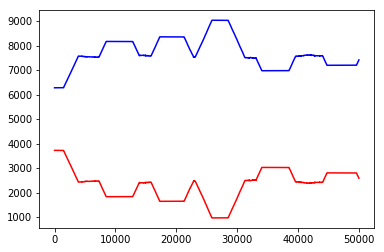

In [114]:
plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

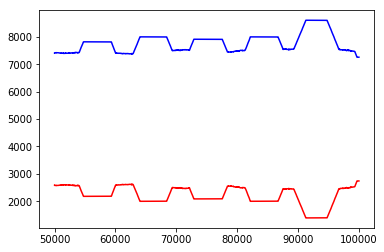

In [115]:
#Plotting graph of T and R rate in original dataset to narrow down index choices (minimize computation time)
#50k at a time also to minimize computation time and chance for computer to freeze :(
ori_t = []
ori_r = []
idx = []
for x in range(50000,100000):
    idx.append(x)
    sub_df = dos_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)
plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

In [244]:
%%time
#Eyeballing the choices of index, use this loop to calculate the T/R index of 10k of the dataset from those index
#to find the one where the ratio is closest to 1
best_ori_idx = 0
curr_best_ori_diff = 999
ori_t = 0
ori_r = 0
best_new_idx = 0
curr_best_new_diff = 999
new_t = 0
new_r = 0
all_ori_ratio = []
all_new_ratio = []
for begin_index in [100,2000,7000,10000,20000,23000,27000,31000,36000,41000,50000]:
    sub_df = dos_formatted[begin_index:begin_index+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    print("there are {}T and {}R".format(ori_T_count,ori_R_count))
    ori_ratio = ori_T_count/ori_R_count
    if ori_ratio > 1:
        ori_ratio = 1/ori_ratio
    all_ori_ratio.append(ori_ratio)
    new_df,new_df_label = splitTheDf(begin_index, sub_df)
    new_ratio = Counter(new_df_label)[1]/Counter(new_df_label)[0]
    if new_ratio > 1:
        new_ratio = 1/new_ratio
    all_new_ratio.append(new_ratio)
    ori_diff = abs(ori_ratio-1)
    new_diff = abs(new_ratio-1)
    print("ori ratio of {} with {} difference from 1".format(ori_ratio, ori_diff))
    print("new ratio of {} with {} difference from 1".format(new_ratio,new_diff))
    if new_diff > 1:
        new_diff = 1/new_diff
    if ori_diff < curr_best_ori_diff:
        curr_best_ori_diff = ori_diff
        best_ori_idx = begin_index
        ori_t = ori_T_count
        ori_r = ori_R_count
    if new_diff < curr_best_new_diff:
        curr_best_new_diff = new_diff
        best_new_idx = begin_index 
        new_t = Counter(new_df_label)[1]
        new_r = Counter(new_df_label)[0]
        
        
'''
8mins for 100 x 10000 operations, not cool man XD
CPU times: user 8min 3s, sys: 1.53 s, total: 8min 5s
Wall time: 8min 7s

'''
        
        
        

there are 3724T and 6276R
ori ratio of 0.5933715742511153 with 0.4066284257488847 difference from 1
new ratio of 0.41607497869923316 with 0.5839250213007668 difference from 1
there are 3445T and 6555R
ori ratio of 0.5255530129672006 with 0.4744469870327994 difference from 1
new ratio of 0.536754507628294 with 0.463245492371706 difference from 1
there are 2473T and 7527R
ori ratio of 0.3285505513484788 with 0.6714494486515212 difference from 1
new ratio of 0.8442759385981136 with 0.15572406140188644 difference from 1
there are 1834T and 8166R
ori ratio of 0.2245897624295861 with 0.7754102375704139 difference from 1
new ratio of 0.514810876500076 with 0.48518912349992405 difference from 1
there are 1646T and 8354R
ori ratio of 0.1970313622216902 with 0.8029686377783098 difference from 1
new ratio of 0.43937644341801385 with 0.5606235565819861 difference from 1
there are 2472T and 7528R
ori ratio of 0.3283740701381509 with 0.6716259298618491 difference from 1
new ratio of 0.84700870531579

In [245]:
print("Best original index is: ",best_ori_idx,"with ratio ",ori_ratio," of {}T and {}R".format(ori_t,ori_r))
print("Best new index is: ",best_new_idx,"with ratio ",new_ratio," of {}T and {}R".format(new_t,new_r))


Best original index is:  100 with ratio  0.34898151895319035  of 3724T and 6276R
Best new index is:  50000 with ratio  0.9103448275862069  of 4752T and 5220R


In [342]:
# Use the best index to finalize the 10k subset
begin_index = 50000
sub_df = dos_formatted[begin_index:begin_index+10000]
new_df, new_label = splitTheDf(begin_index,sub_df)

In [345]:
new_df_labelled = new_df.copy()
new_df_labelled['Label'] = new_label

In [346]:
# Slightly modified Levenshtein distance where index of edit matters
# because 00001111 is 1 regular and 1 attack while 01011010 is 2 regular (in DoS case)
def calc_distance(bin_str):
    distance = 0
    for idx,val in enumerate(bin_str):
        if val != "0":
            distance += (idx + int(val, 16))
    return distance

In [347]:
# Verifying function
print(calc_distance("00000000"))
print(calc_distance("00001111"))
print(calc_distance("11110000"))
print(calc_distance("01010101"))
print(calc_distance("00101011"))

0
26
10
20
23


In [349]:
# Add a new column of 29 CAN-ID distance using the function
new_df_labelled['ID Distance'] = new_df_labelled['String 29-ID'].apply(lambda x: calc_distance(x))

In [350]:
new_df_labelled.head()

,String 29-ID,Array 29-ID,Attack count,Label,ID Distance
0,000003700000043f000004400000015300000002000001...,"[0000, 0370, 0000, 043f, 0000, 0440, 0000, 015...",18,1,1405
1,03700000043f0000044000000153000000020000013000...,"[0370, 0000, 043f, 0000, 0440, 0000, 0153, 000...",17,1,1667
2,0000043f00000440000001530000000200000130000001...,"[0000, 043f, 0000, 0440, 0000, 0153, 0000, 000...",18,1,1546
3,043f000004400000015300000002000001300000013100...,"[043f, 0000, 0440, 0000, 0153, 0000, 0002, 000...",17,1,1673
4,0000044000000153000000020000013000000131000001...,"[0000, 0440, 0000, 0153, 0000, 0002, 0000, 013...",18,1,1541


In [409]:
#Split data to training-test, 80:20, randomized
new_train, new_test = np.split(new_df_labelled.sample(frac=1), [int(.8*len(new_df_labelled))])
new_train_label = new_train['Label']
new_train = new_train.drop(columns=['Label',"Array 29-ID","String 29-ID","Attack count"])
new_test_label = new_test['Label']
new_test = new_test.drop(columns=['Label',"Array 29-ID","String 29-ID","Attack count"])

In [410]:
new_train.head()

,ID Distance
1394,4641
1026,4478
2459,4787
3982,4582
634,4658


In [416]:
table_names = ["KNN","MLP","SVC","Decision Tree","NB"]
accu_arr = []
rec_arr = []
prec_arr = []
f1_arr = []
perf_arr = []

## KNN-DoS

In [417]:
#KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# print(perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9468671679197995
Recall: 0.9260385005065856
Precision: 0.9651531151003168
F1: 0.9451913133402275


## MLP-DoS

In [418]:
#MLP
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(new_train,new_train_label)
guesses = clf.predict(new_test)
# clf.score(new_train,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses)
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.5052631578947369
Recall: 0.0
Precision: 0.0
F1: 0.0


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVC-DoS

In [419]:
#SVC
classifier = SVC(kernel='linear')
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
# classifier.score(new_train,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses)
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9368421052631579
Recall: 0.9078014184397163
Precision: 0.9624060150375939
F1: 0.9343065693430657


## Tree-DoS

In [420]:
#Decision tree
classifier = DecisionTreeClassifier()
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
# classifier.score(new_train,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses)
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)


Accuracy: 0.9488721804511279
Recall: 0.9179331306990881
Precision: 0.9773462783171522
F1: 0.9467084639498432


## NaiveBayes-DoS

In [421]:
classifier = GaussianNB()
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
# classifier.score(new_train,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses)
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9393483709273183
Recall: 0.9057750759878419
Precision: 0.9696312364425163
F1: 0.9366160293347302


In [423]:
# Create final results table
dos_table = pd.DataFrame()
dos_table["Algo"] = table_names
dos_table ["Accuracy"] = accu_arr
dos_table["Recall"] = rec_arr
dos_table["Precision"] = prec_arr 
dos_table["F1"] = f1_arr

# 29-ID DoS RESULTS

In [367]:
dos_table.set_index('Algo')

,Accuracy,Recall,Precision,F1
Algo,,,,
KNN,0.996992,0.994759,0.998947,0.996849
MLP,0.997494,0.994759,1.000000,0.997373
SVC,0.998997,0.997904,1.000000,0.998951
Decision Tree,0.998997,0.997904,1.000000,0.998951
NB,1.000000,1.000000,1.000000,1.000000


# 29-ID, RPM

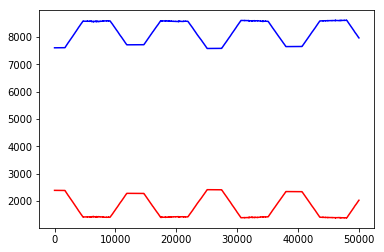

In [224]:
#Find the best index choices
ori_t = []
ori_r = []
idx = []
for x in range(0,50000):
    idx.append(x)
    sub_df = rpm_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)

plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

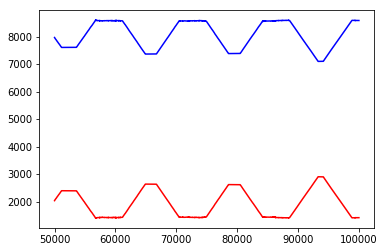

CPU times: user 3min 19s, sys: 1.26 s, total: 3min 20s
Wall time: 3min 21s


In [225]:
%%time
#Find the best index choices
ori_t = []
ori_r = []
idx = []
for x in range(50000,100000):
    idx.append(x)
    sub_df = rpm_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)

plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

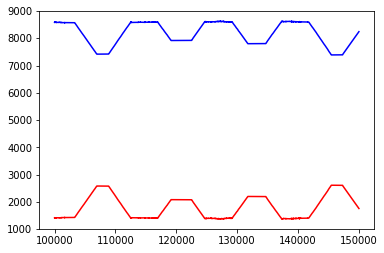

CPU times: user 3min 18s, sys: 1.21 s, total: 3min 19s
Wall time: 3min 21s


In [226]:
%%time
#Find the best index choices
ori_t = []
ori_r = []
idx = []
for x in range(100000,150000):
    idx.append(x)
    sub_df = rpm_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)

plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

In [235]:
%%time
#Find the best 29-ID index
best_ori_idx = 0
curr_best_ori_diff = 999
ori_t = 0
ori_r = 0
best_new_idx = 0
curr_best_new_diff = 999
new_t = 0
new_r = 0
all_ori_ratio = []
all_new_ratio = []
for begin_index in [100,1000,4000,5000,12000,27000,35000,38000,45000,55000,77000,93000,94000,107000,115000,120000,127000,138000,144000,145000]:
    sub_df = rpm_formatted[begin_index:begin_index+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    print("there are {}T and {}R".format(ori_T_count,ori_R_count))
    ori_ratio = ori_T_count/ori_R_count
    if ori_ratio > 1:
        ori_ratio = 1/ori_ratio
    all_ori_ratio.append(ori_ratio)
    new_df,new_df_label = splitTheDf(begin_index, sub_df)
    new_ratio = Counter(new_df_label)[1]/Counter(new_df_label)[0]
    if new_ratio > 1:
        new_ratio = 1/new_ratio
    all_new_ratio.append(new_ratio)
    ori_diff = abs(ori_ratio-1)
    new_diff = abs(new_ratio-1)
    print("ori ratio of {} with {} difference from 1".format(ori_ratio, ori_diff))
    print("new ratio of {} with {} difference from 1".format(new_ratio,new_diff))
    if new_diff > 1:
        new_diff = 1/new_diff
    if ori_diff < curr_best_ori_diff:
        curr_best_ori_diff = ori_diff
        best_ori_idx = begin_index
        ori_t = ori_T_count
        ori_r = ori_R_count
    if new_diff < curr_best_new_diff:
        curr_best_new_diff = new_diff
        best_new_idx = begin_index 
        new_t = Counter(new_df_label)[1]
        new_r = Counter(new_df_label)[0]
        

there are 2392T and 7608R
ori ratio of 0.31440588853838064 with 0.6855941114616193 difference from 1
new ratio of 0.34248788368336025 with 0.6575121163166397 difference from 1
there are 2392T and 7608R
ori ratio of 0.31440588853838064 with 0.6855941114616193 difference from 1
new ratio of 0.34248788368336025 with 0.6575121163166397 difference from 1
there are 1631T and 8369R
ori ratio of 0.19488588839765802 with 0.8051141116023419 difference from 1
new ratio of 0.9526140591345214 with 0.04738594086547865 difference from 1
there are 1419T and 8581R
ori ratio of 0.16536534203472789 with 0.8346346579652721 difference from 1
new ratio of 0.8055404671374253 with 0.19445953286257467 difference from 1
there are 2286T and 7714R
ori ratio of 0.2963443090484833 with 0.7036556909515167 difference from 1
new ratio of 0.3752585850227555 with 0.6247414149772446 difference from 1
there are 2417T and 7583R
ori ratio of 0.3187392852433074 with 0.6812607147566926 difference from 1
new ratio of 0.3026779

In [236]:
print("Best original index is: ",best_ori_idx,"with ratio ",ori_ratio," of {}T and {}R".format(ori_t,ori_r))
print("Best new index is: ",best_new_idx,"with ratio ",new_ratio," of {}T and {}R".format(new_t,new_r))


Best original index is:  94000 with ratio  0.3255567338282078  of 2902T and 7098R
Best new index is:  4000 with ratio  0.29641185647425894  of 5107T and 4865R


In [368]:
# Add the 29-ID Distance
begin_index = 4000
sub_df = rpm_formatted[begin_index:begin_index+10000]
new_df, new_label = splitTheDf(begin_index,sub_df)
new_df_labelled = new_df.copy()
new_df_labelled['Label'] = new_label
new_df_labelled['ID Distance'] = new_df_labelled['String 29-ID'].apply(lambda x: calc_distance(x))

In [370]:
# Split data to train-test, 80:20, randomized
new_train, new_test = np.split(new_df_labelled.sample(frac=1), [int(.8*len(new_df_labelled))])
new_train_label = new_train['Label']
new_train = new_train.drop(columns=['Label',"Array 29-ID","String 29-ID"])
new_test_label = new_test['Label']
new_test = new_test.drop(columns=['Label',"Array 29-ID","String 29-ID"])

In [372]:
table_names = ["KNN","MLP","SVC","Decision Tree","NB"]
accu_arr = []
rec_arr = []
prec_arr = []
f1_arr = []
perf_arr = []

## KNN-RPM

In [373]:
#KNN
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9969924812030075
Recall: 0.9940769990128332
Precision: 1.0
F1: 0.9970297029702971


## MLP-RPM

In [374]:
#MLP
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(new_train,new_train_label)
guesses = clf.predict(new_test)
clf.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9994987468671679
Recall: 0.9990128331688055
Precision: 1.0
F1: 0.9995061728395062


## SVC-RPM

In [375]:
#SVC
classifier = SVC(kernel='linear')
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9994987468671679
Recall: 0.9990128331688055
Precision: 1.0
F1: 0.9995061728395062


## TREE-RPM

In [376]:
# DECISION TREE
classifier = DecisionTreeClassifier()
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9994987468671679
Recall: 0.9990128331688055
Precision: 1.0
F1: 0.9995061728395062


## NAIVEBAYES-RPM

In [377]:
#NB
classifier = GaussianNB()
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1: 1.0


# 29-ID RPM RESULTS

In [378]:
# Aggregate results into table
rpm_table = pd.DataFrame()
rpm_table["Algo"] = table_names
rpm_table ["Accuracy"] = accu_arr
rpm_table["Recall"] = rec_arr
rpm_table["Precision"] = prec_arr 
rpm_table["F1"] = f1_arr

rpm_table.set_index('Algo')

,Accuracy,Recall,Precision,F1
Algo,,,,
KNN,0.996992,0.994077,1.0,0.997030
MLP,0.999499,0.999013,1.0,0.999506
SVC,0.999499,0.999013,1.0,0.999506
Decision Tree,0.999499,0.999013,1.0,0.999506
NB,1.000000,1.000000,1.0,1.000000


# 29-ID FUZZY

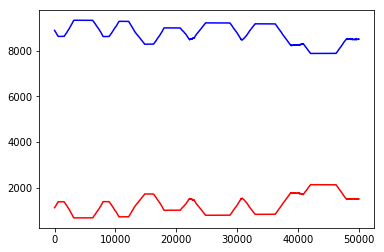

In [290]:
#Finding the best index options
ori_t = []
ori_r = []
idx = []
for x in range(0,50000):
    idx.append(x)
    sub_df = fuzzy_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)

plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

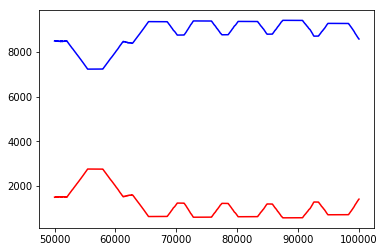

In [291]:
#Finding the best index options
ori_t = []
ori_r = []
idx = []
for x in range(50000,100000):
    idx.append(x)
    sub_df = fuzzy_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)

plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

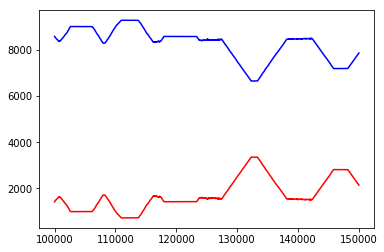

In [292]:
#Finding the best index options
ori_t = []
ori_r = []
idx = []
for x in range(100000,150000):
    idx.append(x)
    sub_df = fuzzy_formatted.iloc[x:x+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_t.append(ori_T_count)
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    ori_r.append(ori_R_count)

plt. plot(idx, ori_t, label = "true", color="red")
plt. plot(idx, ori_r, label = "regular",color="blue")
plt.show()

In [319]:
#Slightly modified split df function (only used by fuzzy so far)
def splitTheDfBy(idx=0,the_df=pd.DataFrame(),by=29,N = 10000):
    canid_29str = ""
    canid_29arr = []
    new_df_str = []
    new_df_arr = []
    new_label_arr = []
    atk_count_df = []
    for idx in range(0,N):
        if idx + by <= N:
            canid_29str = "".join(the_df.iloc[idx:idx+by,1])
            canid_29arr = [x for x in the_df.iloc[idx:idx+by,1]]
            atk_count = 0
            cur_label = 0
            for label in [x for x in the_df.iloc[idx:idx+by,3]]:
                if label == "T":
                    atk_count  += 1
                    cur_label = 1
            new_df_str.append(canid_29str)
            new_df_arr.append(canid_29arr)
            new_label_arr.append(cur_label)
            atk_count_df.append(atk_count)
    new_df = pd.DataFrame(new_df_str, columns = ["String {}-ID".format(by)])
    new_df["Array {}-ID".format(by)] = new_df_arr
    new_df["Attack count"] = atk_count_df
    return new_df,new_label_arr

In [320]:
%%time
# Find best index
best_ori_idx = 0
curr_best_ori_diff = 999
ori_t = 0
ori_r = 0
best_new_idx = 0
curr_best_new_diff = 999
new_t = 0
new_r = 0
all_ori_ratio = []
all_new_ratio = []
for begin_index in [50,4000,8500,11000,15500,20000,22000,27000,30500,40000,45000,50000,55000,56000,57000,60500,67000,70000,75000,96000,100100,105000,111000,117000,120000,127000,130000,131000,131500,132000,133000,140000,147000,150000]:
    sub_df = fuzzy_formatted[begin_index:begin_index+10000]
    ori_T_count = sub_df[sub_df['Label'] == "T"].shape[0]
    ori_R_count = sub_df[sub_df['Label'] == "R"].shape[0]
    print("there are {}T and {}R".format(ori_T_count,ori_R_count))
    ori_ratio = ori_T_count/ori_R_count
    if ori_ratio > 1:
        ori_ratio = 1/ori_ratio
    all_ori_ratio.append(ori_ratio)
    new_df,new_df_label = splitTheDfBy(begin_index, sub_df,19)
    new_ratio = Counter(new_df_label)[1]/Counter(new_df_label)[0]
    if new_ratio > 1:
        new_ratio = 1/new_ratio
    all_new_ratio.append(new_ratio)
    ori_diff = abs(ori_ratio-1)
    new_diff = abs(new_ratio-1)
    print("ori ratio of {} with {} difference from 1".format(ori_ratio, ori_diff))
    print("there are {}T and {}R".format(Counter(new_df_label)[1],Counter(new_df_label)[0]))
    print("new ratio of {} with {} difference from 1".format(new_ratio,new_diff))
    print("-----")
    if new_diff > 1:
        new_diff = 1/new_diff
    if ori_diff < curr_best_ori_diff:
        curr_best_ori_diff = ori_diff
        best_ori_idx = begin_index
        ori_t = ori_T_count
        ori_r = ori_R_count
    if new_diff < curr_best_new_diff:
        curr_best_new_diff = new_diff
        best_new_idx = begin_index 
        new_t = Counter(new_df_label)[1]
        new_r = Counter(new_df_label)[0]
        

there are 1137T and 8863R
ori ratio of 0.12828613336342096 with 0.871713866636579 difference from 1
there are 2729T and 7253R
new ratio of 0.3762581000965118 with 0.6237418999034883 difference from 1
-----
there are 668T and 9332R
ori ratio of 0.07158165452207459 with 0.9284183454779255 difference from 1
there are 1671T and 8311R
new ratio of 0.2010588376849958 with 0.7989411623150042 difference from 1
-----
there are 1383T and 8617R
ori ratio of 0.16049669258442614 with 0.8395033074155739 difference from 1
there are 3420T and 6562R
new ratio of 0.521182566290765 with 0.478817433709235 difference from 1
-----
there are 715T and 9285R
ori ratio of 0.07700592353257943 with 0.9229940764674206 difference from 1
there are 1749T and 8233R
new ratio of 0.21243775051621522 with 0.7875622494837848 difference from 1
-----
there are 1718T and 8282R
ori ratio of 0.20743781695242694 with 0.7925621830475731 difference from 1
there are 4404T and 5578R
new ratio of 0.7895302975977053 with 0.2104697024

In [321]:
print("Best original index is: ",best_ori_idx,"with ratio ",ori_ratio," of {}T and {}R".format(ori_t,ori_r))
print("Best new index is: ",best_new_idx,"with ratio ",new_ratio," of {}T and {}R".format(new_t,new_r))

Best original index is:  133000 with ratio  0.2721027859051011  of 3352T and 6648R
Best new index is:  60500 with ratio  0.7104180945853324  of 4936T and 5046R


In [431]:
# Add 29-ID Distance
begin_index = 60500
sub_df = fuzzy_formatted[begin_index:begin_index+10000]
new_df, new_label = splitTheDfBy(begin_index,sub_df,29)
new_df_labelled = new_df.copy()
new_df_labelled['Label'] = new_label
new_df_labelled['ID Distance'] = new_df_labelled['String 29-ID'].apply(lambda x: calc_distance(x))

In [432]:
new_df_labelled.head()

,String 29-ID,Array 29-ID,Attack count,Label,ID Distance
0,06580087036b03dc05a60370018f026002a00316032903...,"[0658, 0087, 036b, 03dc, 05a6, 0370, 018f, 026...",12,1,4501
1,0087036b03dc05a60370018f026002a003160329035002...,"[0087, 036b, 03dc, 05a6, 0370, 018f, 0260, 02a...",12,1,4566
2,036b03dc05a60370018f026002a003160329035002b004...,"[036b, 03dc, 05a6, 0370, 018f, 0260, 02a0, 031...",11,1,4501
3,03dc05a60370018f026002a003160329035002b0043f01...,"[03dc, 05a6, 0370, 018f, 0260, 02a0, 0316, 032...",11,1,4460
4,05a60370018f026002a003160329035002b0043f014006...,"[05a6, 0370, 018f, 0260, 02a0, 0316, 0329, 035...",10,1,4399


In [433]:
# Split train-test, 80:20, randomized
new_train, new_test = np.split(new_df_labelled.sample(frac=1), [int(.8*len(new_df_labelled))])
new_train_label = new_train['Label']
new_train = new_train.drop(columns=['Label',"Array 29-ID","String 29-ID","Attack count"])
new_test_label = new_test['Label']
new_test = new_test.drop(columns=['Label',"Array 29-ID","String 29-ID","Attack count"])

In [441]:
new_train.head()

,ID Distance
4585,4751
5560,4263
340,4640
9305,4071
440,4406


In [434]:
table_names = ["KNN","MLP","SVC","Decision Tree","NB"]
accu_arr = []
rec_arr = []
prec_arr = []
f1_arr = []
perf_arr = []

# KNN-FUZZY

In [435]:
#KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9408521303258145
Recall: 0.913604766633565
Precision: 0.9674027339642481
F1: 0.9397344228804902


# MLP-FUZZY

In [436]:
#MLP
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(new_train,new_train_label)
guesses = clf.predict(new_test)
clf.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)


Accuracy: 0.5047619047619047
Recall: 1.0
Precision: 0.5047619047619047
F1: 0.6708860759493671


# SVC-FUZZY

In [ ]:
#SVC
classifier = SVC(kernel='linear')
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

# TREE-FUZZY

In [ ]:
#DECISION TREE
classifier = DecisionTreeClassifier()
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

# NAIVEBAYES-FUZZY

In [439]:
#NB
classifier = GaussianNB()
classifier.fit(new_train,new_train_label)
guesses = classifier.predict(new_test)
classifier.score(new_test,new_test_label)
accu = accuracy_score(new_test_label,guesses)
accu_arr.append(accu)
rec = recall_score(new_test_label,guesses)
rec_arr.append(rec)
prec = precision_score(new_test_label,guesses)
prec_arr.append(prec)
f1 = f1_score(new_test_label,guesses)
f1_arr.append(f1)
# perf = perf_measure(new_test_label,guesses))
# perf_arr.append(perf)
print("Accuracy:",accu)
print("Recall:",rec)
print("Precision:",prec)
print("F1:",f1)
# print("TP, FP, TN, FN\n",perf)

Accuracy: 0.9338345864661655
Recall: 0.8967229394240318
Precision: 0.9699248120300752
F1: 0.931888544891641


# 29-ID FUZZY RESULTS

In [440]:
#Aggregate results to table
fuzz_table = pd.DataFrame()
fuzz_table["Algo"] = table_names
fuzz_table ["Accuracy"] = accu_arr
fuzz_table["Recall"] = rec_arr
fuzz_table["Precision"] = prec_arr 
fuzz_table["F1"] = f1_arr

fuzz_table.set_index('Algo')

,Accuracy,Recall,Precision,F1
Algo,,,,
KNN,0.940852,0.913605,0.967403,0.939734
MLP,0.504762,1.000000,0.504762,0.670886
SVC,0.930326,0.901688,0.957806,0.928900
Decision Tree,0.946366,0.910626,0.981799,0.944874
NB,0.933835,0.896723,0.969925,0.931889


In [400]:
new_df_labelled.head()

,String 29-ID,Array 29-ID,Attack count,Label,ID Distance
0,06580087036b03dc05a60370018f026002a00316032903...,"[0658, 0087, 036b, 03dc, 05a6, 0370, 018f, 026...",12,1,4501
1,0087036b03dc05a60370018f026002a003160329035002...,"[0087, 036b, 03dc, 05a6, 0370, 018f, 0260, 02a...",12,1,4566
2,036b03dc05a60370018f026002a003160329035002b004...,"[036b, 03dc, 05a6, 0370, 018f, 0260, 02a0, 031...",11,1,4501
3,03dc05a60370018f026002a003160329035002b0043f01...,"[03dc, 05a6, 0370, 018f, 0260, 02a0, 0316, 032...",11,1,4460
4,05a60370018f026002a003160329035002b0043f014006...,"[05a6, 0370, 018f, 0260, 02a0, 0316, 0329, 035...",10,1,4399


In [402]:
# Checking the attack count
Counter(new_df_labelled["Attack count"])

Counter({12: 829,
         11: 1375,
         10: 1006,
         9: 551,
         13: 374,
         14: 146,
         15: 57,
         16: 18,
         17: 5,
         8: 323,
         7: 132,
         18: 6,
         6: 71,
         5: 24,
         4: 14,
         3: 6,
         2: 4,
         1: 1,
         0: 5030})

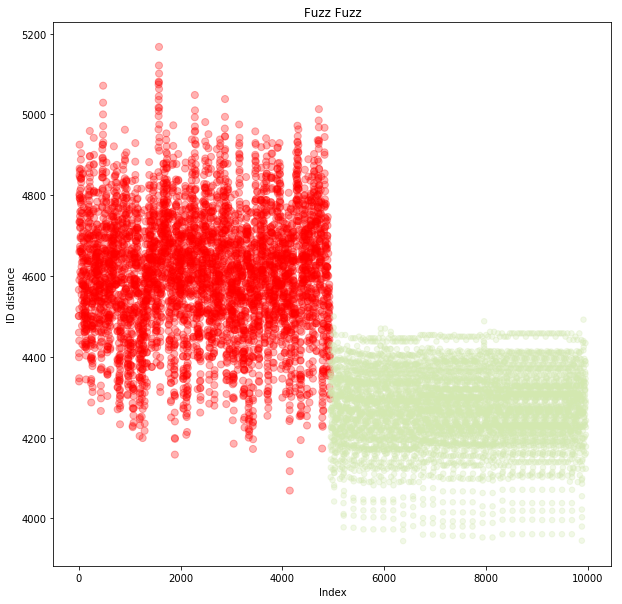

In [445]:
# Plot ID-distance and the index of the data, color coded based whether it has an attack or not
plt.figure(figsize=(10,10))
plt.scatter(range(9972),new_df_labelled["ID Distance"],alpha=0.3,c=c,s=s)
plt.title('Fuzz Fuzz')
plt.xlabel('Index')
plt.ylabel('ID distance')
plt.show()

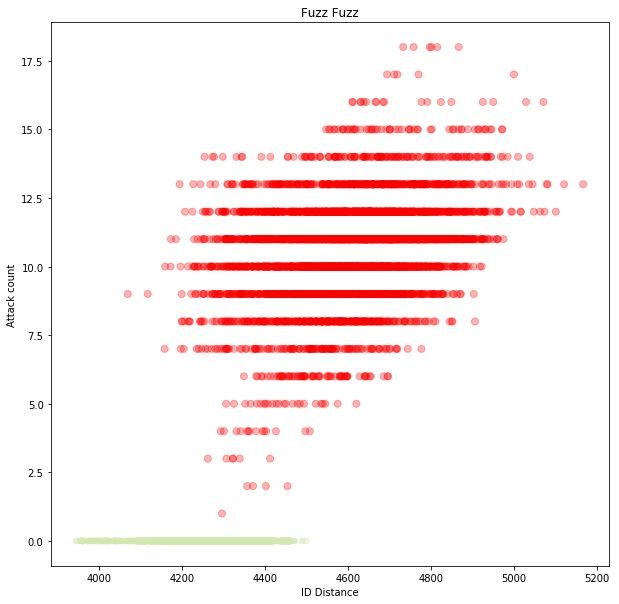

In [408]:
# Plotting ID-distance vs num of attacks in the 29-ID string
plt.figure(figsize=(10,10))
c = []
s = []
for x in new_df_labelled['Label']:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(new_df_labelled["ID Distance"],new_df_labelled["Attack count"],alpha=0.3,c=c,s=s)
plt.title('Fuzz Fuzz')
plt.xlabel('ID Distance')
plt.ylabel('Attack count')
plt.show()